In [1]:
import numpy as np
import librosa

import os
import time
import cmath


# This is to force CPU evaluation since we probably train on a bigger GPU than I have
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


import keras
import keras.layers as layers
from keras import backend as K
from keras.utils import plot_model
from keras import regularizers
from keras import layers

#import matplotlib.pyplot as plt
#%matplotlib inline

Using TensorFlow backend.


In [2]:
# Get shared constants and functions
%run "NN Audio Core.py"

In [6]:
# If on google colab, run this
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Rewriten to use a single stream of data and on the fly creation of batch data

TODO
* Change name from frames to samples everywhere

* Automatic logging of graphs, errors, models etc. for comparison
* Add graph of model
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')

* Look for sources of noise that are close to what I want?  Or generate some clips?

* Add history error plotting to compare different learning models, topologies, etc.

* Why does https://towardsdatascience.com/audio-ai-isolating-vocals-from-stereo-music-using-convolutional-neural-networks-210532383785 only use real component?
* Evaluate different representations of complex numbers in terms of learnability

* Consider generating custom data for goal - male speakers, low voice, specific sounds

In [19]:
# For local data
samples=300000
drive_data = ""

"\\ftargets-CQT-B" + str(FFT_BINS) + "-"
frames = np.memmap("f://audiodata//fsamples-CQT-B" + str(FFT_BINS) + "-" +str(samples), mode='r', dtype=DTYPE, shape=(samples, FFT_BINS, 2))
targets = np.memmap("f://audiodata//ftargets-CQT-B" + str(FFT_BINS) + "-" +str(samples), mode='r', dtype=DTYPE, shape=(samples, FFT_BINS, 2))

In [0]:
# Data access for Colab
# Move data to VM local drive for reliable access
drive_data = '/content/drive/My Drive/Projects/Audio Separation/Data/'
os.chdir(drive_data)

import shutil
samples = 300000
frames_file = "fsamples-B" + str(FFT_BINS) + "-" + str(samples)
targets_file = "ftargets-B"+ str(FFT_BINS) + "-" +str(samples)
shutil.copy(frames_file, "/content/")
shutil.copy(targets_file, "/content/")

os.chdir("/content")

# for testing identity mapping : #frames = np.memmap("ftargets-"+str(samples), mode='r', dtype=DTYPE, shape=(samples, FFT_BINS, 1))

frames = np.memmap("fsamples-B" + str(FFT_BINS) + "-" + str(samples), mode='r', dtype=DTYPE, shape=(samples, FFT_BINS, 2))
targets = np.memmap("ftargets-B"+ str(FFT_BINS) + "-" +str(samples), mode='r', dtype=DTYPE, shape=(samples, FFT_BINS, 2))

In [20]:
# Code to generate input, target, and verification data
# From https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, input_array, target_array, batch_size=32, shuffle=True):
        'Initialization'
        self.input_array = input_array
        self.target_array = target_array
        self.dim = (WINDOW_SIZE,FFT_BINS) # Input data shape
        self.batch_size = batch_size
        self.list_IDs = list_IDs  # the set of allowed IDs to use as addresses for frames and target samples
        self.n_channels = 2
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, FFT_BINS, self.n_channels), dtype=DTYPE)

        # Generate data
        half_win = WINDOW_SIZE // 2
        for i, ID in enumerate(list_IDs_temp):
            # Store sample & target
            X[i,] = self.input_array[ID-half_win:ID+half_win+1,:,:]
            y[i] = self.target_array[ID,:,:]

        return X, y

In [21]:
# Prepare the generator
validation_split = 0.05
batch_size = 64

# Available IDs
all_IDs = np.arange(WINDOW_SIZE//2, frames.shape[0]-WINDOW_SIZE//2)
np.random.shuffle(all_IDs)

validation_cut = int(np.floor(len(all_IDs) * (1-validation_split)))
validation_IDs = all_IDs[validation_cut:]
train_IDs = all_IDs[0:validation_cut-1]

training_generator = DataGenerator(train_IDs, frames, targets, batch_size=batch_size)
validation_generator = DataGenerator(validation_IDs, frames, targets, batch_size=batch_size)


In [3]:
# Network building functions
def conv_set(depth, kernel, strides, name, input, padding='valid'):
  conv = layers.Conv2D(depth, kernel_size=kernel, strides=strides, padding=padding, activity_regularizer=regularizers.l2(L2Reg), use_bias = False, name=name+"_conv")(input)
  norm = layers.BatchNormalization()(conv)
  return layers.LeakyReLU(alpha=ALPHA, name=name+"_LRelu")(norm)

def pool_set(size, strides, name, input):
  pool = layers.MaxPooling2D(pool_size=size, strides=strides, name=name+"_pool")(input)
  return layers.LeakyReLU(alpha=ALPHA)(pool)


# from https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff

# TODO make this actually work!!!
def res_conv_block(f, filters, name, block, X):
  F1, F2, F3 = filters 
  X_shortcut = X
  ## Main path
  # First component
  X = conv_set(F1, (1,1), (1,1), name+"_res_conv_" + block + "_1", X)
  X = conv_set(F2, (f,f), (1,1), name+"_res_conv_" + block + "_2", X)
  X = conv_set(F3, (1,1), (1,1), name+"_res_conv_" + block + "_3", X)

  #X_shortcut = conv_set(F3, (1,1), (2,2), name+"_res_conv_shortcut_" + block, X)
  #X = layers.add([X, X_shortcut])
  return X

def Bus(bus, name, width, X):
  B = layers.Dense(width, activity_regularizer=regularizers.l2(L2Reg), name="bus_input_dense"+name)(layers.Flatten()(X))
  B = layers.concatenate([bus, B], name="bus_merge_"+name)
  B = layers.Dense(width, activity_regularizer=regularizers.l2(L2Reg), name="bus_dense_"+name)(B)
  return B


In [18]:
# Real model (eventually)
ALPHA = 0.05
L2Reg = 0.0000 # bumping this up to 0.000005 didn't seem very good

inputs = layers.Input(shape=(WINDOW_SIZE,FFT_BINS,2)) # Full window

NARROW_VIEW = 15
BUS_WIDTH = 100

# WARNING - if I put a constant in the lambda function, it causes an error when loading the model
def sub_samples(samples, n, window_size):
    half_cut = (window_size - n) // 2
    return samples[:,half_cut:-half_cut,:,:]
    
# process inputs into subsets of interest
input_slice = layers.Lambda(sub_samples, arguments = {'n':1, 'window_size':WINDOW_SIZE}, name="targetslice")(inputs)
narrow_view = layers.Lambda(sub_samples, arguments = {'n':NARROW_VIEW, 'window_size':WINDOW_SIZE}, name="narrow_view")(inputs)

# broad view
X = conv_set(32,(3,6), (1,3), "bconv0", inputs)
X = conv_set(32,(3,6), (1,2), "bconv1", X)
X = res_conv_block(5, filters=[32, 32, 128], name="br_res", block="A", X=X )
X = conv_set(64, (3,6), (1,2), "bconv2", X)
side = conv_set(16, (4,10), (2,3), "side_prep1", X)
bus = layers.Dense(BUS_WIDTH, activity_regularizer=regularizers.l2(L2Reg), name="bus_initial_dense")(layers.Flatten()(side))  # Start of side path
#X = res_conv_block(5, filters=[32, 32, 128], name="br_res", block="C", X=X )
X = conv_set(128, (4,6), (2,2), "bconv3", X)
X = conv_set(16, (4,6), (1,1), "bconv4", X)
side = conv_set(16, (2,3), (1,1), "side_prep2", X)
bus = Bus(bus, "b3", BUS_WIDTH, side)
X = pool_set((2,4), (1,1), "bpool2", X)
X = layers.BatchNormalization(name="b_norm")(X)
flat_b = layers.Flatten(name="flat_b")(X)

# narrow view
X = conv_set(32, (3,7), (1,2), "conv0", narrow_view)
X = conv_set(64, (3,7), (1,2), "conv1", narrow_view)
X = res_conv_block(3, filters=[32, 32, 128], name="nr_res", block="A", X=X )
X = conv_set(64, (3,7), (1,2), "conv2", narrow_view)
X = pool_set((2,3), (1,2), "pool1", X)
#X = res_conv_block(3, filters=[32, 32, 128], name="nr_res", block="B", X=X )
X = conv_set(128, (3,7), (1,2), "conv3", X)
X = res_conv_block(3, filters=[32, 32, 128], name="nr_res", block="C", X=X )
X = conv_set(128, (3,7), (1,2), "conv4", X)
X = conv_set(16, (3,7), (1,2), "conv5", X)
X = pool_set((2,3), (1,2), "pool2", X)
X = layers.BatchNormalization(name="n_norm")(X)
flat_n = layers.Flatten(name="flat_n")(X)

flat = layers.concatenate([flat_b, flat_n, bus], name="merge_modes")

flat_in = layers.Flatten(name="flatten")(input_slice)

flat_drop = layers.Dropout(rate=0.2)(flat)  # Add this later
dense0 = layers.Dense(500, activity_regularizer=regularizers.l2(L2Reg))(flat_drop)
d0a = layers.LeakyReLU(alpha=ALPHA)(dense0)
merge1 = layers.concatenate([d0a, flat_in], name="merge_input")

dense1 = layers.Dense(300, activity_regularizer=regularizers.l2(L2Reg))(merge1)
d1a = keras.layers.LeakyReLU(alpha=ALPHA)(dense1)
#dense2 = layers.Dense(200, )(d1a)
#d2a = keras.layers.LeakyReLU(alpha=ALPHA)(dense2)
merged = layers.concatenate([d1a, flat_in])
flat_outputs = layers.Dense(2 * FFT_BINS, activation='linear')(merged)
outputs = layers.Reshape((FFT_BINS,2))(flat_outputs)

model = keras.models.Model(inputs=[inputs], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 55, 480, 2)   0                                            
__________________________________________________________________________________________________
bconv0_conv (Conv2D)            (None, 53, 159, 32)  1152        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_148 (BatchN (None, 53, 159, 32)  128         bconv0_conv[0][0]                
__________________________________________________________________________________________________
bconv0_LRelu (LeakyReLU)        (None, 53, 159, 32)  0           batch_normalization_148[0][0]    
____________________________________________________________________________________________

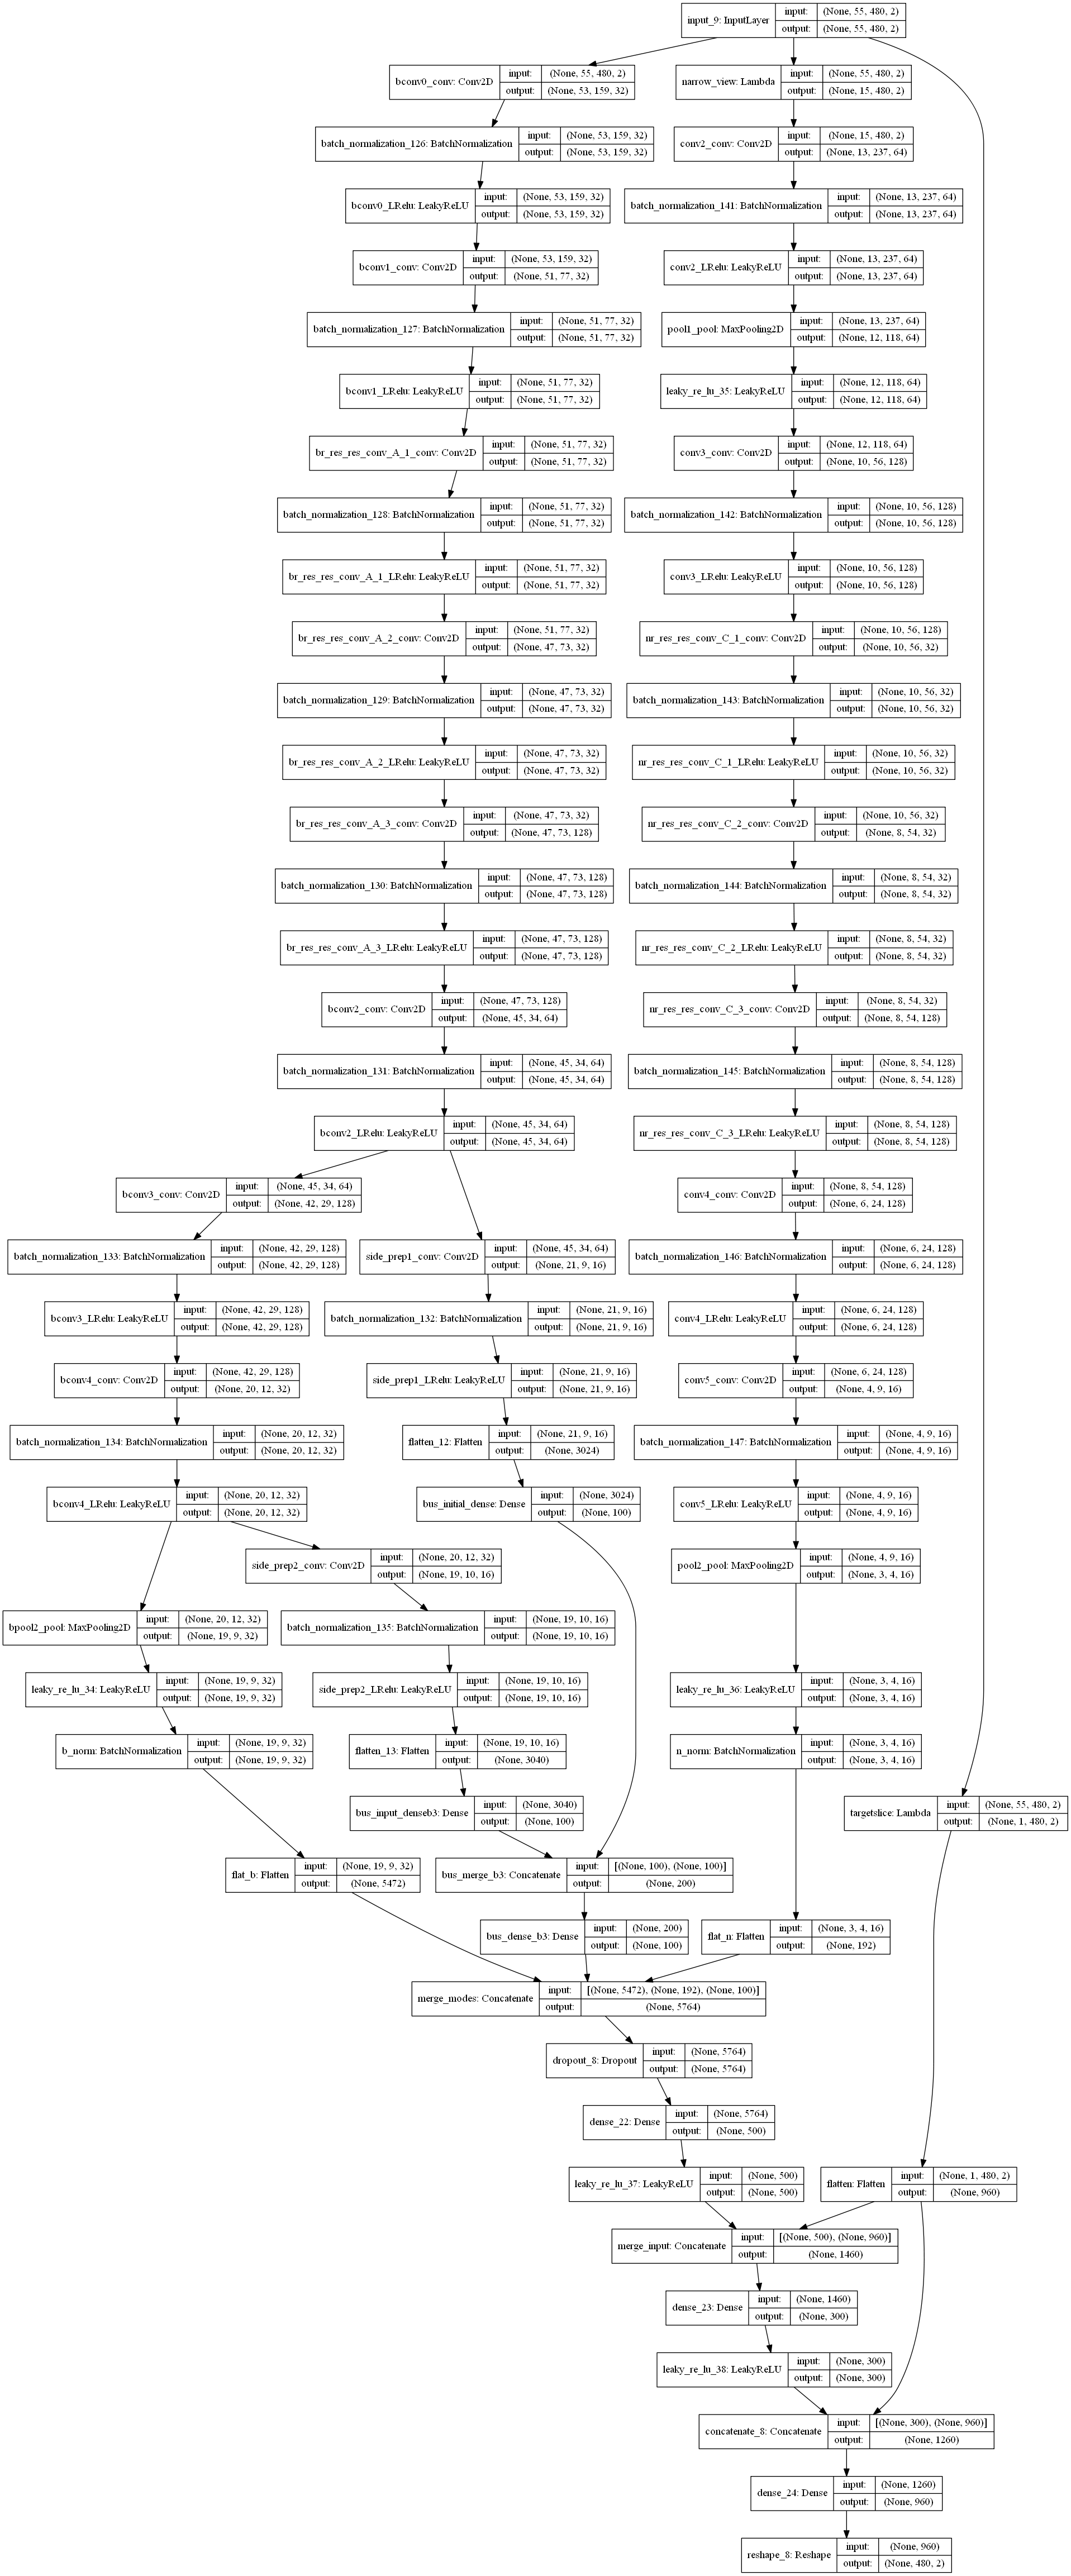

In [17]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
# fit_generator
stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(drive_data + "Best_cqt_model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Max queue size is to fix "UserWarning: The input 6833 could not be retrieved. It could be because a worker has died."
#  10 didn't work once for 500K samples, 1025 bins but tried 5 and that seemed to
#  Trying a fix by copying to local directory - may boost speed as well?
hist = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=10, callbacks = [stopper, save_best]) #, max_queue_size=10)

In [0]:
now = time.strftime('%Y-%m-%d_%H-%M')
model.save(drive_data + "model_cqt_"+now+".h5")

In [20]:
history = hist

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim((0, 2 * history.history['loss'][0])) # because sometimes there are stupid spikes in error
plt.show()

#plt.savefig('test.png')
print("Validation loss mean 5+ epochs {0:.4}".format(np.mean(history.history['val_loss'][5:])))
print("Lowest validation loss {0:.4}".format(np.min(history.history['val_loss'][5:])))
print("Frames ", frames.shape[0])

NameError: ignored

In [0]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
fft = get_ft(wav)
#print(fft.shape)

In [0]:
# Full round trip test
file = "p232_001.wav"

verify_file = "Assets\\DataShareArchive\\Test\\Noisy\\" + file
clean_file = "Assets\\DataShareArchive\\Test\\Clean\\" + file


# Sample output is (samples, bins) all converted to magnitude
def get_samples(file):
    wav, rate = librosa.core.load(file)
    samples = abs(get_ft(wav).T) # organized as bins, frames so we need to transpose them to frames, bins
    return samples

# Only need this for testing at this point?  Could still make it a 'top' type shared function
def clip_frames(file):
    samples = get_samples(file)
    print(samples.shape)
    frames = np.empty((samples.shape[0], WINDOW_SIZE, FFT_BINS, 1))
    half_win = WINDOW_SIZE//2
    for i in range(half_win, samples.shape[0]-half_win):
        frames[i,:,:,0] = samples[i-half_win:i+half_win+1,:]
    return frames


def clean_clip(model, n_file):
    verify_frames = clip_frames(n_file)
    output_targets = model.predict([verify_frames])
    wav, rate = librosa.core.load(n_file)
    n_fft = get_ft(wav)
    fft = rebuild_fft(output_targets, n_fft)
    return fft, inv_ft(fft)


p_fft, p_wav = clean_clip(model, verify_file)
    
wav, rate = librosa.core.load(clean_file)
c_fft = get_ft(wav)


def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(ft), ref=np.max), y_axis='cqt_hz', x_axis='time')

print("Cleaned clip")

err_fft = c_fft - p_fft
print("Average abs err vs clean = ", np.mean(abs(err_fft)))

display_fft(p_fft)
Audio(p_wav,rate=22050)


In [0]:
def draw(wav):
    fft = get_ft(wav)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='cqt_hz', x_axis='time')
    return fft

In [0]:
wav, rate = librosa.core.load(verify_file)
n_fft = draw(wav)

err_fft = c_fft - n_fft
print("Average abs err vs clean = ", np.mean(abs(err_fft)))

print("Noisy file")
Audio(wav, rate=rate)

In [0]:
wav, rate = librosa.core.load(clean_file)
c_fft = draw(wav)

print("Clean sample")
Audio(wav, rate=rate)

In [0]:
cut_fft = n_fft-p_fft
display_fft(cut_fft)

print("Removed audio")
print("Average cut value = ", np.mean(abs(cut_fft)))

cut_wav = inv_ft(cut_fft)
Audio(cut_wav,rate=22050)


In [0]:
#%%capture cap
print(model.summary())
#with open('output.txt', 'w') as f:
#    f.write(cap.stdout)


In [0]:
fresh_wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\Noisy\\p232_019.wav")
Audio(fresh_wav, rate=rate)

Test & reference stuff 

In [18]:
# Real model (eventually)
ALPHA = 0.05
L2Reg = 0.0000 # bumping this up to 0.000005 didn't seem very good

inputs = layers.Input(shape=(WINDOW_SIZE,FFT_BINS,1)) # Full window

NARROW_VIEW = 15
BUS_WIDTH = 100

# WARNING - if I put a constant in the lambda function, it causes an error when loading the model
def sub_samples(samples, n, window_size):
    half_cut = (window_size - n) // 2
    return samples[:,half_cut:-half_cut,:,:]
    
# process inputs into subsets of interest
input_slice = layers.Lambda(sub_samples, arguments = {'n':1, 'window_size':WINDOW_SIZE}, name="targetslice")(inputs)
narrow_view = layers.Lambda(sub_samples, arguments = {'n':NARROW_VIEW, 'window_size':WINDOW_SIZE}, name="narrow_view")(inputs)

# zoomed out view
X = layers.AveragePooling2D(pool_size=(3,3), strides=(2,2), name="broad_pool1")(inputs)
X = conv_set(32,(3,6), (1,2), "bconv1", X)
X = res_conv_block(5, filters=[32, 32, 128], name="br_res", block="A", X=X )
#X = res_conv_block(5, filters=[32, 32, 128], name="br_res", block="B", X=X )
X = conv_set(64, (3,6), (1,2), "bconv2", X)
side = conv_set(16, (4,10), (1,3), "side_prep1", X)
bus = layers.Dense(BUS_WIDTH, activity_regularizer=regularizers.l2(L2Reg), name="bus_initial_dense")(layers.Flatten()(side))  # Start of side path
#X = res_conv_block(5, filters=[32, 32, 128], name="br_res", block="C", X=X )
X = conv_set(128, (4,6), (1,2), "bconv3", X)
X = conv_set(32, (4,6), (1,2), "bconv4", X)
side = conv_set(16, (2,3), (1,1), "side_prep2", X)
bus = Bus(bus, "b3", BUS_WIDTH, side)
X = pool_set((2,4), (1,2), "bpool2", X)
X = layers.BatchNormalization(name="b_norm")(X)
flat_b = layers.Flatten(name="flat_b")(X)

# narrow view
X = conv_set(32, (3,7), (1,2), "conv0", narrow_view)
X = conv_set(64, (3,7), (1,2), "conv1", narrow_view)
X = res_conv_block(3, filters=[32, 32, 128], name="nr_res", block="A", X=X )
X = conv_set(64, (3,7), (1,2), "conv2", narrow_view)
X = pool_set((2,3), (1,2), "pool1", X)
#X = res_conv_block(3, filters=[32, 32, 128], name="nr_res", block="B", X=X )
X = conv_set(128, (3,7), (1,2), "conv3", X)
X = res_conv_block(3, filters=[32, 32, 128], name="nr_res", block="C", X=X )
X = conv_set(128, (3,7), (1,2), "conv4", X)
X = conv_set(32, (3,7), (1,2), "conv5", X)
X = pool_set((2,3), (1,2), "pool2", X)
X = layers.BatchNormalization(name="n_norm")(X)
flat_n = layers.Flatten(name="flat_n")(X)

flat = layers.concatenate([flat_b, flat_n, bus], name="merge_modes")

flat_in = layers.Flatten(name="flatten")(input_slice)

flat_drop = layers.Dropout(rate=0.2)(flat)  # Add this later

dense0 = layers.Dense(700, activity_regularizer=regularizers.l2(L2Reg))(flat_drop)
d0a = layers.LeakyReLU(alpha=ALPHA)(dense0)
merge1 = layers.concatenate([d0a, flat_in], name="merge_input")

dense1 = layers.Dense(500, activity_regularizer=regularizers.l2(L2Reg))(merge1)
d1a = keras.layers.LeakyReLU(alpha=ALPHA)(dense1)
dense2 = layers.Dense(300, )(d1a)
d2a = keras.layers.LeakyReLU(alpha=ALPHA)(dense2)
merged = layers.concatenate([d2a, flat_in])
outputs = layers.Dense(FFT_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 55, 513, 1)   0                                            
__________________________________________________________________________________________________
broad_pool1 (AveragePooling2D)  (None, 27, 256, 1)   0           input_7[0][0]                    
__________________________________________________________________________________________________
bconv1_conv (Conv2D)            (None, 25, 126, 32)  576         broad_pool1[0][0]                
__________________________________________________________________________________________________
narrow_view (Lambda)            (None, 15, 513, 1)   0           input_7[0][0]                    
____________________________________________________________________________________________

In [0]:
ft = clip_frames(test_file)
tt = clip_targets(test_file)

print(ft.shape)
print(tt.shape)

#Frame / target check  -  don't use first row because it might be zeroed out
r = 10
print(tt[0,r])
print(ft[0,r,TARGET_COL:TARGET_COL+1,0])

# Round trip test
new_fft = rebuild_fft(tt, fft)
print(new_fft.shape)
new_wav = inv_ft(new_fft)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

Audio(new_wav,rate=22050)

In [0]:
    
def show_fft(wav):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max), y_axis='log', x_axis='time')

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

print(new_fft.shape)

#show_fft(wav)
#show_fft(new_wav)
#Audio(wav, rate=22050)


In [0]:
# Test stuff for hacking around    
    
a = np.array([[1+2j, 3+4j, 1.5+2.5j],[5+6j,7+8j, 5.5+6.5j]])
print(a)
a1 = a[0]
print(a1)
ar = a1.real
ai = a1.imag

st = np.zeros((6))
st[0:3] = ar
st[3:6] = ai
print(ar.shape, ai.shape, st.shape)
print(ar, ai)
print(st)


In [0]:
# ''do nothing' model that should be able to guess outputs from outputs

inputs = layers.Input(shape=(FFT_BINS*2,))
dense1 = layers.Dense(2000, activation='relu')(inputs)
dense2 = layers.Dense(2000, activation='relu')(dense1)
#flat = layers.Flatten()(dense)
#flat_in = layers.Flatten()(inputs)
#merged = layers.concatenate([flat, flat_in])
merged = layers.concatenate([dense2, inputs])
linear = layers.Dense(2000, activation='linear')(merged)
outputs = layers.Dense(2*FFT_BINS, activation='linear')(linear)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

model.fit(targets, targets, epochs=1, batch_size=32)